In [68]:
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    classification_report, confusion_matrix, roc_auc_score, 
    precision_recall_curve, auc, roc_curve, f1_score
)
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt
import seaborn as sns

In [69]:
# Load processed data
print("Loading processed data...")
df = pd.read_csv('../data_processed/admissions_features_enhanced.csv')
print(f"Dataset shape: {df.shape}")
print(f"\nFirst few rows:\n{df.head()}")

Loading processed data...
Dataset shape: (101766, 51)

First few rows:
   encounter_id  patient_nbr  age_num  sex_female  time_in_hospital  \
0       2278392      8222157        5           1                 1   
1        149190     55629189       15           1                 3   
2         64410     86047875       25           1                 2   
3        500364     82442376       35           0                 2   
4         16680     42519267       45           0                 1   

   num_lab_procedures  num_procedures  num_medications  number_outpatient  \
0                  41               0                1                  0   
1                  59               0               18                  0   
2                  11               5               13                  2   
3                  44               1               16                  0   
4                  51               0                8                  0   

   number_emergency  ...  diag_any_diab

In [70]:
# Identify target column (common names in diabetes readmission dataset)
# Adjust this based on your actual target column name


possible_targets = ['readmitted', 'readmitted_30', 'target', 'label', 'readmitted_binary']
for col in possible_targets:
    if col in df.columns:
        target_col = col
        break

if target_col is None:
    print("\nAvailable columns:")
    print(df.columns.tolist())
    raise ValueError("Could not find target column. Please specify the target column name.")

print(f"\nUsing target column: {target_col}")


Using target column: label


In [71]:
target_col = 'label'
# Separate features and target
X = df.drop(columns=[target_col])
y = df[target_col]

# Check class distribution
print(f"\nClass distribution:")
print(y.value_counts())
print(f"Readmission rate: {y.mean():.2%}")

# Split data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"\nTraining set size: {len(X_train)}")
print(f"Test set size: {len(X_test)}")



Class distribution:
label
0    90409
1    11357
Name: count, dtype: int64
Readmission rate: 11.16%

Training set size: 81412
Test set size: 20354


In [72]:
# Calculate scale_pos_weight for class imbalance
scale_pos_weight = (y_train == 0).sum() / (y_train == 1).sum()
print(f"Scale pos weight: {scale_pos_weight:.2f}")

print(f"\n{'='*70}")
print("TRAINING XGBOOST WITH OPTIMIZED PARAMETERS")
print("="*70)

# Optimized parameters for imbalanced medical data
# Using lower max_depth and stronger regularization to prevent overfitting
params = {
    'objective': 'binary:logistic',
    'eval_metric': 'auc',
    'max_depth': 4,  # Shallower trees
    'learning_rate': 0.01,  # Lower learning rate
    'n_estimators': 1000,  # More trees with early stopping
    'subsample': 0.7,  # Sample 70% of data for each tree
    'colsample_bytree': 0.7,  # Use 70% of features per tree
    'min_child_weight': 5,  # Require more samples per leaf
    'gamma': 1,  # Minimum loss reduction for split
    'reg_alpha': 1,  # L1 regularization
    'reg_lambda': 5,  # L2 regularization
    'scale_pos_weight': scale_pos_weight,  # Handle class imbalance
    'random_state': 42,
    'tree_method': 'hist',
    'early_stopping_rounds': 100  # Stop if no improvement for 100 rounds
}

model = xgb.XGBClassifier(**params)

# Train with evaluation set
model.fit(
    X_train, y_train,
    eval_set=[(X_train, y_train), (X_test, y_test)],
    verbose=50
)

# Get prediction probabilities
y_pred_proba = model.predict_proba(X_test)[:, 1]


Scale pos weight: 7.96

TRAINING XGBOOST WITH OPTIMIZED PARAMETERS
[0]	validation_0-auc:0.62377	validation_1-auc:0.62678
[50]	validation_0-auc:0.64269	validation_1-auc:0.64349
[100]	validation_0-auc:0.64664	validation_1-auc:0.64693
[150]	validation_0-auc:0.64940	validation_1-auc:0.64828
[200]	validation_0-auc:0.65260	validation_1-auc:0.64977
[250]	validation_0-auc:0.65562	validation_1-auc:0.65078
[300]	validation_0-auc:0.65902	validation_1-auc:0.65204
[350]	validation_0-auc:0.66230	validation_1-auc:0.65343
[400]	validation_0-auc:0.66534	validation_1-auc:0.65410
[450]	validation_0-auc:0.66789	validation_1-auc:0.65478
[500]	validation_0-auc:0.67035	validation_1-auc:0.65589
[550]	validation_0-auc:0.67251	validation_1-auc:0.65641
[600]	validation_0-auc:0.67474	validation_1-auc:0.65708
[650]	validation_0-auc:0.67695	validation_1-auc:0.65770
[700]	validation_0-auc:0.67911	validation_1-auc:0.65834
[750]	validation_0-auc:0.68097	validation_1-auc:0.65869
[800]	validation_0-auc:0.68290	validatio

In [73]:
# Test multiple thresholds
thresholds = np.arange(0.05, 0.95, 0.05)
results = []

for thresh in thresholds:
    y_pred = (y_pred_proba >= thresh).astype(int)
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
    
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0
    f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
    specificity = tn / (tn + fp) if (tn + fp) > 0 else 0
    
    results.append({
        'threshold': thresh,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'specificity': specificity,
        'tp': tp,
        'fp': fp,
        'tn': tn,
        'fn': fn
    })

results_df = pd.DataFrame(results)

# Find different optimal thresholds for different objectives
max_f1_idx = results_df['f1'].idxmax()
optimal_f1_threshold = results_df.loc[max_f1_idx, 'threshold']

# Find threshold where precision >= 0.30 and maximize recall
high_precision_df = results_df[results_df['precision'] >= 0.30]
if len(high_precision_df) > 0:
    optimal_precision_threshold = high_precision_df.loc[high_precision_df['recall'].idxmax(), 'threshold']
else:
    optimal_precision_threshold = 0.5

print("\nThreshold Options:")
print(f"\n1. MAX F1 SCORE (Balanced): {optimal_f1_threshold:.2f}")
print(f"   Precision: {results_df.loc[max_f1_idx, 'precision']:.3f}")
print(f"   Recall: {results_df.loc[max_f1_idx, 'recall']:.3f}")
print(f"   F1: {results_df.loc[max_f1_idx, 'f1']:.3f}")

if len(high_precision_df) > 0:
    hp_idx = results_df[results_df['threshold'] == optimal_precision_threshold].index[0]
    print(f"\n2. HIGH PRECISION (≥30%): {optimal_precision_threshold:.2f}")
    print(f"   Precision: {results_df.loc[hp_idx, 'precision']:.3f}")
    print(f"   Recall: {results_df.loc[hp_idx, 'recall']:.3f}")
    print(f"   F1: {results_df.loc[hp_idx, 'f1']:.3f}")

# Use the max F1 threshold
chosen_threshold = optimal_f1_threshold
y_pred_optimal = (y_pred_proba >= chosen_threshold).astype(int)


Threshold Options:

1. MAX F1 SCORE (Balanced): 0.50
   Precision: 0.175
   Recall: 0.561
   F1: 0.267

2. HIGH PRECISION (≥30%): 0.70
   Precision: 0.322
   Recall: 0.104
   F1: 0.157


In [75]:
print(f"\n{'='*70}")
print(f"RESULTS USING THRESHOLD = {chosen_threshold:.2f}")
print("="*70)

print("\nClassification Report:")
print(classification_report(y_test, y_pred_optimal, 
                          target_names=['No Readmission', 'Readmitted <30 days']))

cm = confusion_matrix(y_test, y_pred_optimal)
print("\nConfusion Matrix:")
print(cm)

tn, fp, fn, tp = cm.ravel()
print(f"\nTrue Negatives: {tn:,} | False Positives: {fp:,}")
print(f"False Negatives: {fn:,} | True Positives: {tp:,}")

# Calculate clinical metrics
sensitivity = tp / (tp + fn)
specificity = tn / (tn + fp)
ppv = tp / (tp + fp) if (tp + fp) > 0 else 0
npv = tn / (tn + fn) if (tn + fn) > 0 else 0

print(f"\nClinical Metrics:")
print(f"  Sensitivity (Recall): {sensitivity:.1%} - Catching {sensitivity:.1%} of readmissions")
print(f"  Specificity: {specificity:.1%} - Correctly identifying {specificity:.1%} of non-readmissions")
print(f"  PPV (Precision): {ppv:.1%} - {ppv:.1%} of flagged patients actually readmit")
print(f"  NPV: {npv:.1%} - {npv:.1%} of cleared patients don't readmit")

# ROC-AUC and PR-AUC
roc_auc = roc_auc_score(y_test, y_pred_proba)
precision_curve, recall_curve, _ = precision_recall_curve(y_test, y_pred_proba)
pr_auc = auc(recall_curve, precision_curve)

print(f"\nModel Discrimination:")
print(f"  ROC-AUC: {roc_auc:.4f}")
print(f"  PR-AUC: {pr_auc:.4f}")

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

def performance(pred, actual):
    acc = accuracy_score(pred, actual)
    prec = precision_score(pred, actual)
    rec = recall_score(pred, actual)
    f1 = f1_score(pred, actual)
    con = confusion_matrix(pred, actual)
    return acc, prec, rec, f1

acc, prec, rec, f1 = performance(y_pred, y_test)
print("Precision Score is ; ", prec)
print("Recall Score is ; ", rec)
print("F1-Score Score is ; ", f1)



RESULTS USING THRESHOLD = 0.50

Classification Report:
                     precision    recall  f1-score   support

     No Readmission       0.92      0.67      0.78     18083
Readmitted <30 days       0.18      0.56      0.27      2271

           accuracy                           0.66     20354
          macro avg       0.55      0.61      0.52     20354
       weighted avg       0.84      0.66      0.72     20354


Confusion Matrix:
[[12087  5996]
 [  998  1273]]

True Negatives: 12,087 | False Positives: 5,996
False Negatives: 998 | True Positives: 1,273

Clinical Metrics:
  Sensitivity (Recall): 56.1% - Catching 56.1% of readmissions
  Specificity: 66.8% - Correctly identifying 66.8% of non-readmissions
  PPV (Precision): 17.5% - 17.5% of flagged patients actually readmit
  NPV: 92.4% - 92.4% of cleared patients don't readmit

Model Discrimination:
  ROC-AUC: 0.6606
  PR-AUC: 0.2088
Precision Score is ;  0.00044033465433729633
Recall Score is ;  1.0
F1-Score Score is ;  0.0008

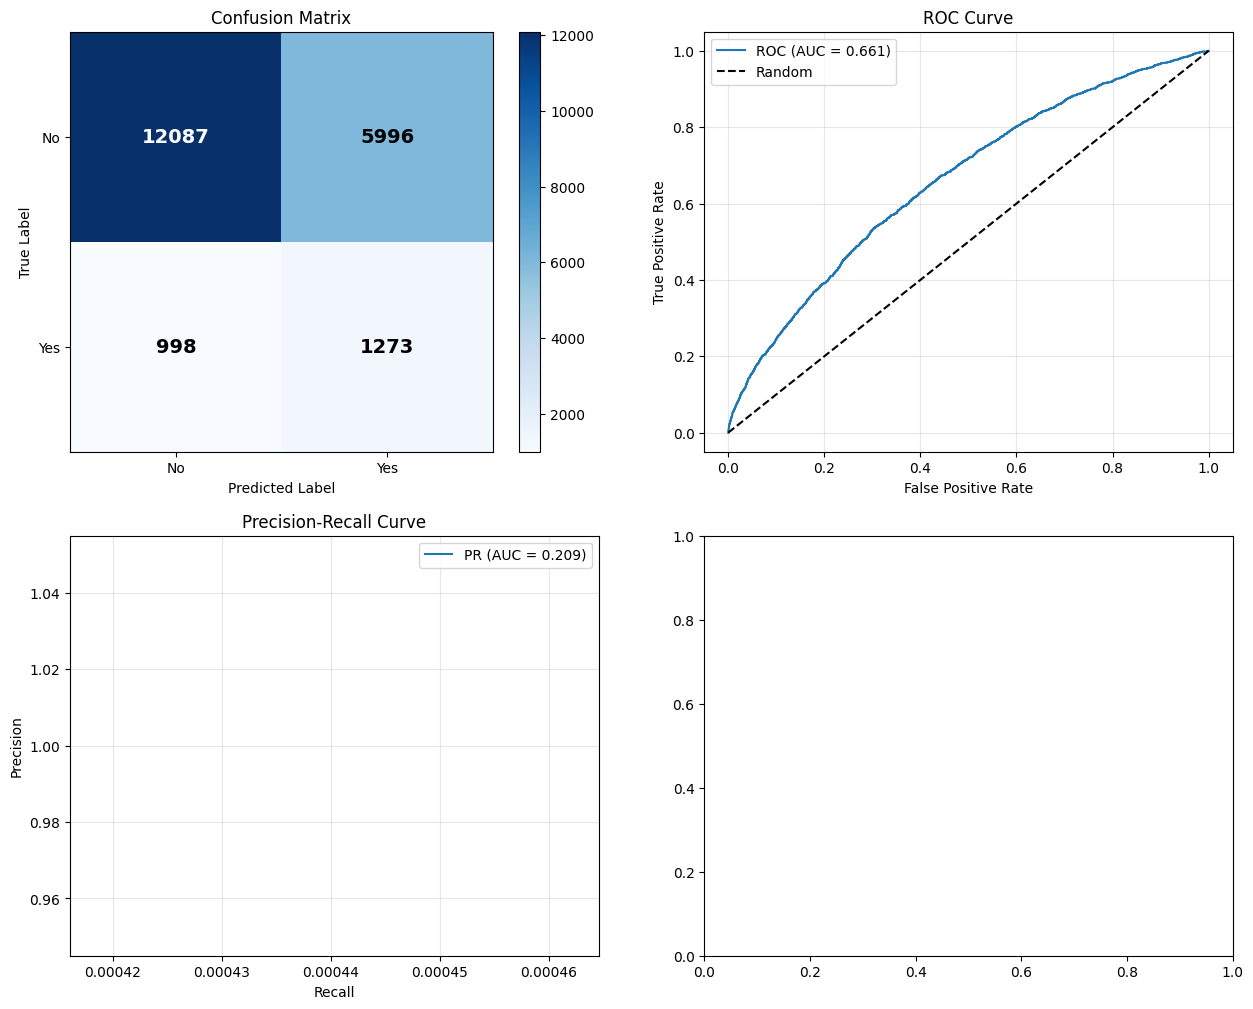

In [66]:
fig, axes = plt.subplots(2, 2, figsize=(15, 12))
# 1. Confusion Matrix
im = axes[0, 0].imshow(cm, cmap='Blues', aspect='auto')
axes[0, 0].set_title('Confusion Matrix')
axes[0, 0].set_ylabel('True Label')
axes[0, 0].set_xlabel('Predicted Label')
axes[0, 0].set_xticks([0, 1])
axes[0, 0].set_yticks([0, 1])
axes[0, 0].set_xticklabels(['No', 'Yes'])
axes[0, 0].set_yticklabels(['No', 'Yes'])
# Add text annotations
for i in range(2):
    for j in range(2):
        axes[0, 0].text(j, i, str(cm[i, j]), ha='center', va='center', color='white' if cm[i, j] > cm.max()/2 else 'black', fontsize=14, fontweight='bold')
plt.colorbar(im, ax=axes[0, 0])
# 2. ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
axes[0, 1].plot(fpr, tpr, label=f'ROC (AUC = {roc_auc:.3f})')
axes[0, 1].plot([0, 1], [0, 1], 'k--', label='Random')
axes[0, 1].set_xlabel('False Positive Rate')
axes[0, 1].set_ylabel('True Positive Rate')
axes[0, 1].set_title('ROC Curve')
axes[0, 1].legend()
axes[0, 1].grid(alpha=0.3)

# 3. Precision-Recall Curve
axes[1, 0].plot(recall, precision, label=f'PR (AUC = {pr_auc:.3f})')
axes[1, 0].set_xlabel('Recall')
axes[1, 0].set_ylabel('Precision')
axes[1, 0].set_title('Precision-Recall Curve')
axes[1, 0].legend()
axes[1, 0].grid(alpha=0.3)